<header style="background-color: rgb(0, 62, 92); color: white; margin-top: 20px; padding:28px; ">
  <img src="images/Xlogo.png" alt="Transposition of a vector" title="Vector transposition" width="115" style="float: left;">
  <p style=" text-align: center; font-size: 32px;">   
   <strong> Deep Learning in Finance MAP548 </strong></p>
  <p style=" text-align: center; font-size: 25px;"><strong> Project 1 -  Deep pricing and calibration </strong></p>
  <p style=" text-align: center; font-size: 20px;"> Eduardo Abi Jaber </p>
</header>

# <font color='red'>PLEASE ENTER YOUR FULL NAMES HERE:</font>



- MANSARD Diane
- POTTIER Clément

<font color='red'>**DEADLINE: March 2 (5:00 pm)**</font>

<font color='red'>**PLease send both pdf ipynb files with name : Name1_Name2_Project1**</font>

# The two factor Bergomi model

The two factor Bergomi Model (L Bergomi, 2005) under the risk-neutral filtered probability space $(\Omega, \mathcal F,(\mathcal F_t)_{t\geq 0}, \mathbb Q )$  has the following dynamics:


\begin{equation}
  \begin{aligned}
    dS_t &= S_t\sqrt{V_t}dB_t, \quad S_0>0;\\
    X_t &= X_t^1 + X_t^2,\\
    V_t &= \xi \exp{\left(X_t-\frac{1}{2} \mathbb{V}[X_t] \right)},\\
      X_t^i &=  \eta_i\int_0^t e^{-\kappa_i(t-s)} dW_s,
  \end{aligned}
  \end{equation}

where $ B=\rho W + \sqrt{1-\rho^2} W^{\perp}$ with $(W,W^{\perp})$ a two-dimensional Brownian motion, $\rho \in [-1,1]$.

$X_t^i$ is a Ornstein–Uhlenbeck (Gaussian) process such that $X_t^i \sim \mathcal{N}(0, \eta_i^2\frac{(1-e^{-2\kappa_i t})}{2\kappa_i})$. Note that both $X^1$ and $X^2$ are driven by the same Brownian motion.

Recall $\mathbb V[(X+Y)] = \mathbb V[X] + \mathbb V[Y] + 2\mathbb {COV}[X,Y]$.

In addition, we fix $\kappa_2=2.6$, thus there are in total five calibratable model parameters: $(\xi, \kappa_1, \eta_1, \eta_2, \rho)$.

We are interested in computing the price of European style contingent claims, with payoff $g(S_T)$ for some function $g$:
$$
C_t = \mathbb{E} \left[g(S_T) \vert \mathcal F_t) \right].
$$

For European vanilla call options, with $g(x) = (x-K)^{+}$ with strike $K$; no closed form formula to compute $g(S_T)$

Suggested range of model parameters for training:

$\xi \in [0.03,0.25], \kappa_1 \in [10,60], \eta_1 \in [5,35],\eta_2 \in [1,5],\rho \in [-0.9,-0.1]$

# Your task

Inspired by the deep pricer for the one factor Bergomi model. Implement a deep pricer for the two factor Bergomi model. You have to generate your own training set using a scheme of your choice that you have to detail (use the fixed grid for strikes and maturities below).

Once your NN is trained, showcase the train and test error, and perform a calibration on the market implied volatility surface that was used in the one factor Bergomi and comment. 

Also provide/display the output prices of the NN of the set of parameters set 1, 2 and 3 below. 

You have to provide a notebook that compiles, together with the trained weights of your Neural Networks that we can load with the command: *model_iv.load_weights('2FBergomiNNWeights.h5')*. 

(!) The actual training of NN is not difficult, the difficult part is to get good data (and lots of it), so be careful about your simulation schemes (training might require a larger dataset than for 1 factor bergomi).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm.notebook import tqdm
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, Flatten, Reshape
import tensorflow as tf
tf.config.run_functions_eagerly(True)

from tensorflow import keras
from sklearn.model_selection import train_test_split

## Let's start simulating Xt1 and Xt2 using a recursive method

##### [We first study how to simulate one price, to then implement at a larger scale.]

Define the process for a 1-factor model:

$$
\widetilde X_t = e^{\kappa t}X_t = \int_0^t e^{\kappa s} dW_s,
$$

so that

$$
\widetilde X_{t_{j+1}} = \widetilde X_{t_j} + \int_{t_{j}}^{t_{j+1}}e^{\kappa s} dW_s =  \
    \widetilde X_{t_j}+\sqrt{\frac{e^{2 \kappa t_{j+1}}-e^{2 \kappa t_{j}}}{2\kappa}}Y_j,
$$

with $t_0 = 0, \quad t_N = T, \quad Y_i  \sim \mathcal{N}(0, 1)$ iid. Thus we first simulate $\widetilde X_{t_{j+1}}$ and then convert back to $X_t$ by:

$$
 X_t = e^{-\kappa t} \widetilde X_t.
$$

We then finally multiply by the corresponding eta to get the final value of the process for each Xt.

In [2]:
xi, kappa_1, eta_1, eta_2, rho, = 0.14, 35, 20, 3, -0.5
kappa_2 = 2.6
T = 2
n_steps = 1000 # number of time steps
N_sims = 50 # number of simulations for Monte Carlo 

dt = T/n_steps
tt = np.linspace(0., T, n_steps + 1)

In [3]:
times_to_find = [0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ] # list of the value to search for

indices = {time: np.argmin(np.abs(tt - time)) for time in times_to_find} # si approx numérique prend le plus proche, mieux pour stocker les indices: 

for time, index in indices.items():
    print(f"Time interval of {time}:", f"index {index} of the matrix tt")

Time interval of 0.1: index 50 of the matrix tt
Time interval of 0.3: index 150 of the matrix tt
Time interval of 0.6: index 300 of the matrix tt
Time interval of 0.9: index 450 of the matrix tt
Time interval of 1.2: index 600 of the matrix tt
Time interval of 1.5: index 750 of the matrix tt
Time interval of 1.8: index 900 of the matrix tt
Time interval of 2.0: index 1000 of the matrix tt


In [4]:
np.random.seed(42)

def gen_bm_path(n_steps,N_sims):
    w1 = np.random.normal(0, 1, (n_steps, N_sims))
    return w1

w1 = gen_bm_path(n_steps,N_sims)

In [5]:
# Simulation of Xt1
exp1_Xt1 = np.exp(kappa_1*tt[1:])
exp2_Xt1 = np.exp(2*kappa_1*tt)

diff_exp2_Xt1 = np.diff(exp2_Xt1)
std_vec_Xt1 = np.sqrt(diff_exp2_Xt1/(2*kappa_1))[:,np.newaxis] #to be broadcasted columnwise 
exp1_Xt1 = exp1_Xt1[:,np.newaxis]
Xt1 = np.concatenate((np.zeros(w1.shape[1])[np.newaxis, :],(1/exp1_Xt1)*np.cumsum(std_vec_Xt1*w1, axis = 0)))
Xt1 = eta_1*Xt1

In [6]:
# Simulation of Xt2
exp1_Xt2 = np.exp(kappa_2*tt[1:])
exp2_Xt2 = np.exp(2*kappa_2*tt)

diff_exp2_Xt2 = np.diff(exp2_Xt2)
std_vec_Xt2 = np.sqrt(diff_exp2_Xt2/(2*kappa_2))[:,np.newaxis] #to be broadcasted columnwise 
exp1_Xt2 = exp1_Xt2[:,np.newaxis]
Xt2 = np.concatenate((np.zeros(w1.shape[1])[np.newaxis, :],(1/exp1_Xt2)*np.cumsum(std_vec_Xt2*w1, axis = 0)))
Xt2 = eta_2*Xt2

In [7]:
# Creation of Xt
Xt = Xt1 + Xt2

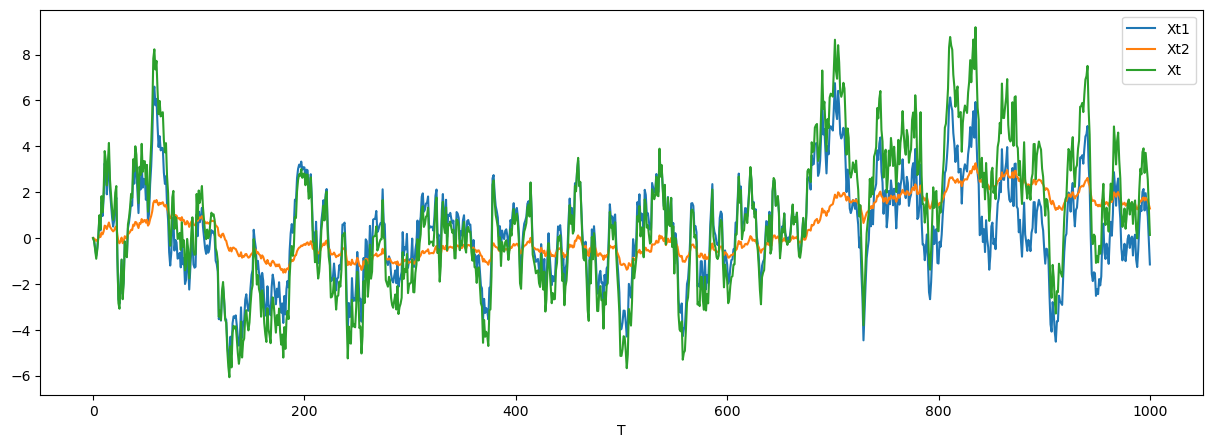

In [8]:
i_ind = 1
plt.figure(figsize=(15,5))
plt.plot(Xt1[:,i_ind],label='Xt1')
plt.plot(Xt2[:,i_ind],label='Xt2')
plt.plot(Xt[:,i_ind],label='Xt')
plt.xlabel('T')
plt.legend()
plt.show()

## Simulation of Vt and St with fixed parameters

The variance is computed as follow, we use the properties of the ItÔ intergrals :

$
\mathbb{V}[X_t] = \mathbb{V}[X_t^1] + \mathbb{V}[X_t^2] + 2 \mathbb{COV}[X_t^1, X_t^2]
$

$
\mathbb{V}[X_t] = \eta_1 \int_0^t e^{-\kappa_1 (t-s)} dW_s + \eta_2 \int_0^t e^{-\kappa_2 (t-s)} dW_s + 2\eta_1 \eta_2 \int_0^t e^{-\kappa_1 (t-s)} e^{-\kappa_2 (t-s)} ds
$

$
\mathbb{V}[X_t] = \eta_1^2 \frac{1 - e^{-2\kappa_1 t}}{2\kappa_1} + \eta_2^2 \frac{1 - e^{-2 \kappa_2 t}}{2 \kappa_2} + \eta_1 \eta_2 e^{-t(\kappa_1 + \kappa_2)}\int_0^t e^{(\kappa_1 + \kappa_2)s} ds
$

$
\mathbb{V}[X_t] = \eta_1^2 \frac{1 - e^{-2\kappa_1 t}}{2\kappa_1} + \eta_2^2 \frac{1 - e^{-2\kappa_2 t}}{2\kappa_2} + \eta_1 \eta_2 \frac{1 - e^{-t(\kappa_1 + \kappa_2)}}{\kappa_1 + \kappa_2}
$


In [9]:
var1 = eta_1**2*(1-np.exp(-2*kappa_1*tt))/(2*kappa_1)
var2 = eta_2**2*(1-np.exp(-2*kappa_2*tt))/(2*kappa_2)
covar = eta_1*eta_2*(1-np.exp(-(kappa_1+kappa_2)*tt))/(kappa_1+kappa_2) 
var = var1 + var2 + 2*covar

Vt = xi * np.exp(Xt - 0.5 * var[:, np.newaxis]) #variance calculated for each time step 

In [10]:
w1 = gen_bm_path(n_steps,N_sims)
w2 = gen_bm_path(n_steps,N_sims)

In [11]:
S0 = 100
r = 0.02 

log_S = np.ones(N_sims).reshape(1,-1)*np.log(S0)
epochs_iter_j = tqdm(range(n_steps), desc="iteration", miniters=2000)
for j in epochs_iter_j:
    log_S_next = log_S[j]-0.5*Vt[j]*dt+np.sqrt(Vt[j]*dt)*\
        (rho*w1[j]+np.sqrt(1-rho**2)*w2[j]) 
    log_S=np.append(log_S,log_S_next.reshape(1,-1),axis=0)

S = np.exp(log_S)

iteration:   0%|          | 0/1000 [00:00<?, ?it/s]

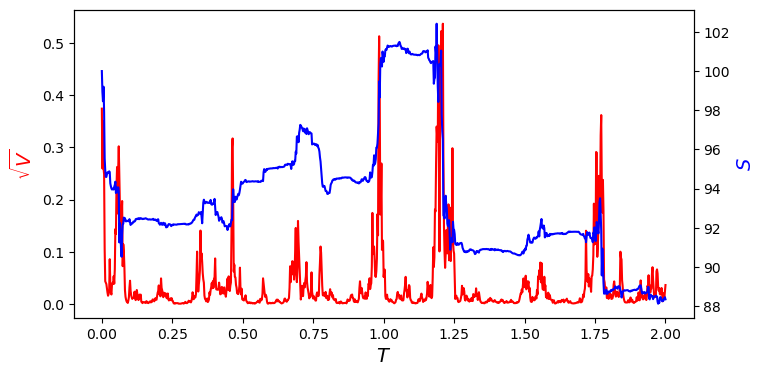

In [12]:
i_ind = 4 # The 4-th simulation
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()
ax2 = ax.twinx()
lns2 = ax2.plot(tt,np.array(S[:,i_ind]), '-b',label = r'$S$')
lns1 = ax.plot(tt,np.sqrt(Vt[:,i_ind]), 'r',ls='-', label = r'$\sqrt{V}$')
labs = [l.get_label() for l in lns2+lns1]
ax.set_xlabel(r"$T$",size=14)
ax.set_ylabel(r'$\sqrt{V}$', color='red',size=14)
ax2.set_ylabel(r'$S$', color='blue',size=14)
plt.show()

## Let's now compute the prices of the option with the Monte Carlo method

With K=100 and T=2, the option price is:

In [13]:
K = 100
price = np.exp(-r*T) * np.mean(np.maximum(S[-1] - K, 0)) #Do the average of the payoffs of all the simulations
print(f"The option payoff is {price:.2f}")

The option payoff is 10.02


With K=100 and the requested time intervals:

In [14]:
for time, index in indices.items():
    price = np.exp(-r * (T - time)) * np.mean(np.maximum(S[index] - K, 0))
    print(f"The option payoff at time {time} is {price:.2f}")

The option payoff at time 0.1 is 3.10
The option payoff at time 0.3 is 3.69
The option payoff at time 0.6 is 4.18
The option payoff at time 0.9 is 9.00
The option payoff at time 1.2 is 8.06
The option payoff at time 1.5 is 7.75
The option payoff at time 1.8 is 9.03
The option payoff at time 2.0 is 10.42


Option prices at different strikes:

In [3]:
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])*100

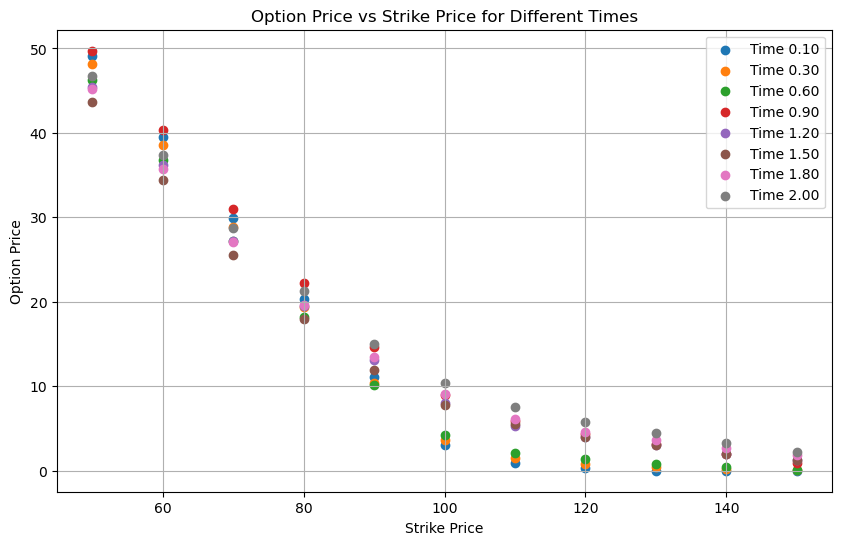

In [16]:
prices = {}

for time, index in indices.items():
    prices[time] = []
    for strike in strikes:
        price = np.exp(-r * (T - time)) * np.mean(np.maximum(S[index] - strike, 0))
        prices[time].append((strike, price))

# Plot the results
plt.figure(figsize=(10, 6))
for time, prices_data in prices.items():
    strikes, prices_values = zip(*prices_data)
    plt.scatter(strikes, prices_values, label=f'Time {time:.2f}')

plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Option Price vs Strike Price for Different Times')
plt.legend()
plt.grid(True)
plt.show()

The option price decreases when the strike price increases, which is an encouraging sign that our simulation makes sense. 

## Let's implement the result in an array 

In [17]:
parameters = [xi, kappa_1, eta_1, eta_2, rho]
x = np.array(parameters).reshape(1, -1) 
x.shape


(1, 5)

In [18]:
values_list = [value for sublist in prices.values() for value in sublist]
y = np.array(values_list)

y.shape 

(88, 2)

In [19]:
print(y)

[[5.00000000e+01 4.91631750e+01]
 [6.00000000e+01 3.95360456e+01]
 [7.00000000e+01 2.99089162e+01]
 [8.00000000e+01 2.03699709e+01]
 [9.00000000e+01 1.11279266e+01]
 [1.00000000e+02 3.09676409e+00]
 [1.10000000e+02 8.85718009e-01]
 [1.20000000e+02 3.27074101e-01]
 [1.30000000e+02 0.00000000e+00]
 [1.40000000e+02 0.00000000e+00]
 [1.50000000e+02 0.00000000e+00]
 [5.00000000e+01 4.82114428e+01]
 [6.00000000e+01 3.85457277e+01]
 [7.00000000e+01 2.88800127e+01]
 [8.00000000e+01 1.93956460e+01]
 [9.00000000e+01 1.03853263e+01]
 [1.00000000e+02 3.68955514e+00]
 [1.10000000e+02 1.46758927e+00]
 [1.20000000e+02 8.53060819e-01]
 [1.30000000e+02 4.66432217e-01]
 [1.40000000e+02 2.34093623e-01]
 [1.50000000e+02 4.07793219e-02]
 [5.00000000e+01 4.62878906e+01]
 [6.00000000e+01 3.67584846e+01]
 [7.00000000e+01 2.72350101e+01]
 [8.00000000e+01 1.82231492e+01]
 [9.00000000e+01 1.01787366e+01]
 [1.00000000e+02 4.17909554e+00]
 [1.10000000e+02 2.07830667e+00]
 [1.20000000e+02 1.42843007e+00]
 [1.300000

# Sample IV surface values

- After different combination of number of simulation and number of training data we noticed that having a significative number of simulation is more important than having a lot of training data to improve the quality of the model. 
- Even if the number of training data simulated is non negligeable, we created a datatrain of size 20k in a respectable amount of time with our computational power (it required 9h to created this one, and it would be complicated to create on a larger datatrain)

In [4]:
N=20000
N_sims = 2000
kappa_2 = 2.
T = 2
n_steps = 1000
dt = T / n_steps
S0 = 100
tt = np.linspace(0, T, n_steps + 1)
strikes = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5])*S0
indices = {time: np.argmin(np.abs(tt - time)) for time in [0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.0]}
r = 0.02

In [5]:
np.random.seed(42)

def gen_bm_path(n_steps,N_sims):
    w1 = np.random.normal(0, 1, (n_steps, N_sims))
    return w1

In [44]:
X_data = np.array([]).reshape(0, 5)
y_data = np.array([]).reshape(0, 88)

for i in tqdm(range(N), desc="Avancement", unit="iter"):
    xi = np.random.uniform(0.03, 0.25)
    kappa_1 = np.random.uniform(10, 60)
    eta_1 = np.random.uniform(5, 35)
    eta_2 = np.random.uniform(1, 5)
    rho = np.random.uniform(-0.9, -0.1)
    
    
    w1 = gen_bm_path(n_steps, N_sims)
    w2 = gen_bm_path(n_steps, N_sims)
    log_S = np.ones(N_sims).reshape(1,-1) * np.log(S0)
    
    log_S = np.ones(N_sims).reshape(1,-1) * np.log(S0)
    
    # sim Xt1
    exp1_Xt1 = np.exp(kappa_1*tt[1:])
    exp2_Xt1 = np.exp(2*kappa_1*tt)

    diff_exp2_Xt1 = np.diff(exp2_Xt1)
    std_vec_Xt1 = np.sqrt(diff_exp2_Xt1/(2*kappa_1))[:,np.newaxis] #to be broadcasted columnwise 
    exp1_Xt1 = exp1_Xt1[:,np.newaxis]
    Xt1 = np.concatenate((np.zeros(w1.shape[1])[np.newaxis, :],(1/exp1_Xt1)*np.cumsum(std_vec_Xt1*w1, axis = 0)))
    Xt1 = eta_1*Xt1
    
    # sim Xt2

    #w_corr = rho * w1 + np.sqrt(1 - rho**2) * w2

    exp1_Xt2 = np.exp(kappa_2*tt[1:])
    exp2_Xt2 = np.exp(2*kappa_2*tt)

    diff_exp2_Xt2 = np.diff(exp2_Xt2)
    std_vec_Xt2 = np.sqrt(diff_exp2_Xt2/(2*kappa_2))[:,np.newaxis] #to be broadcasted columnwise 
    exp1_Xt2 = exp1_Xt2[:,np.newaxis]
    Xt2 = np.concatenate((np.zeros(w1.shape[1])[np.newaxis, :],(1/exp1_Xt2)*np.cumsum(std_vec_Xt2*w1, axis = 0)))
    Xt2 = eta_2*Xt2
    
    Xt = Xt1 + Xt2
    
    #calcul de Vt
    var1 = eta_1**2*(1-np.exp(-2*kappa_1*tt))/(2*kappa_1)
    var2 = eta_2**2*(1-np.exp(-2*kappa_2*tt))/(2*kappa_2)
    covar = eta_1*eta_2*(1-np.exp(-(kappa_1+kappa_2)*tt))/(kappa_1+kappa_2) 
    var = var1 + var2 + 2*covar

    Vt = xi * np.exp(Xt - 0.5 * var[:, np.newaxis])
    
    # discounted!! prices
    for j in range(n_steps):
        log_S_next = log_S[j] - 0.5 * Vt[j] * dt + np.sqrt(Vt[j] * dt) * (rho * w1[j] + np.sqrt(1 - rho**2) * w2[j])
        log_S = np.append(log_S, log_S_next.reshape(1,-1), axis=0)
    
    S = np.exp(log_S)
    prices = {}
    
    for time, index in indices.items():
        prices[time] = []
        for strike in strikes:
            price = np.exp(-r * (T - time)) * np.mean(np.maximum(S[index] - strike, 0))
            prices[time].append(price)

    values_list = [value for sublist in prices.values() for value in sublist]
    y = np.array(values_list)
    X = np.array([xi, kappa_1, eta_1, eta_2, rho]).reshape(1, -1)
    X_data = np.append(X_data, X, axis=0)
    y_data = np.append(y_data, y.reshape(1, -1), axis=0)
    pourcentage = (i + 1) / N * 100
    print(f"\rProgression : {pourcentage:.2f}%", end="", flush=True)
    

Avancement:   0%|          | 0/20000 [00:00<?, ?iter/s]

Progression : 100.00%

In [45]:
print(X_data.shape, y_data.shape)

(20000, 5) (20000, 88)


In [46]:
print("Stats des features X:")
print(pd.DataFrame(X_data).describe())

print("\nStats des labels y:")
print(pd.DataFrame(y_data).describe())


Stats des features X:
                  0             1             2             3             4
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000
mean       0.139733     35.060984     19.950709      2.998564     -0.501921
std        0.063380     14.458089      8.676348      1.151190      0.230896
min        0.030010     10.003982      5.000009      1.000352     -0.899971
25%        0.084909     22.435661     12.371490      2.005818     -0.702494
50%        0.139813     35.190658     19.943424      2.994380     -0.503171
75%        0.194309     47.558675     27.508005      3.998557     -0.301550
max        0.249995     59.999244     34.998204      4.999947     -0.100069

Stats des labels y:
                 0             1             2             3             4   \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean      48.187078     38.602317     29.057022     19.605852     10.427082   
std        0.202210      0.204453   

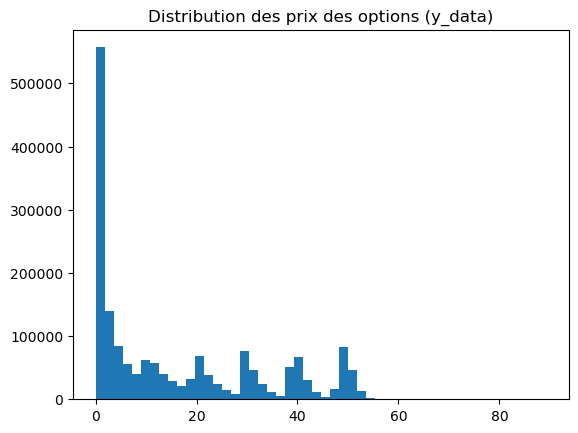

In [ ]:
plt.hist(y_data.flatten(), bins=50)
plt.title("Distribution des prix des options (y_data)")
plt.show()

In [48]:
df_train = pd.DataFrame(X_data, columns=['xi', 'kappa_1', 'eta_1', 'eta_2', 'rho'])
df_train = pd.concat([df_train, pd.DataFrame(y_data)], axis=1)

df_train.to_csv('training_set_N20K_Nsim2000.csv', index=False)

## Preparation of the training data

In [6]:
training_data = pd.read_csv('training_set_N20K_Nsim2000.csv')
training_data = training_data.to_numpy()
X_data = training_data[:,:5]
y_data = training_data[:,5:]
X = X_data
target_y = np.log1p(y_data)

print(training_data.shape)
print('X shape:', X.shape)
print('Y shape:', target_y.shape)

(20000, 93)
X shape: (20000, 5)
Y shape: (20000, 88)


Split the Data between training (85%) and testing (15%) and normalise inputs between $[-1,1]$ and center/standardise outputs. 

In [7]:
#splitting the data to training and testing set
X_indexed = np.concatenate((np.arange(X.shape[0])[np.newaxis].T,X),axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
    X_indexed, target_y, test_size=0.15, random_state=42)

train_index = X_train[:,0].astype(int)
test_index = X_test[:,0].astype(int)
X_train = X_train[:,1:]
X_test = X_test[:,1:]

In [8]:
#Normalising input data x to the interval of [-1, 1]
def input_norm_transform(x, x_min, x_max, norm_min, norm_max):
    return (x-x_min)/(x_max-x_min)*(norm_max-norm_min)+norm_min
def input_norm_transform_inv(x_norm, x_min, x_max, norm_min, norm_max):
    return (x_norm-norm_min)/(norm_max-norm_min)*(x_max-x_min)+x_min

x_max = np.array([np.max(X_train[:,0]),  np.max(X_train[:,1]),  np.max(X_train[:,2]), np.max(X_train[:,3]), np.max(X_train[:,4])])
x_min = np.array([np.min(X_train[:,0]),  np.min(X_train[:,1]),  np.min(X_train[:,2]), np.min(X_train[:,3]), np.min(X_train[:,4])])
x_norm_min = -1
x_norm_max = 1

x_train_transform = input_norm_transform(X_train, x_min, x_max, x_norm_min, x_norm_max)
x_test_transform = input_norm_transform(X_test, x_min, x_max, x_norm_min, x_norm_max)

In [9]:
#Let's check the range for each parameter:
print('x_max:', x_max)
print('x_min:', x_min)

x_max: [ 0.24999495 59.99924387 34.99820427  4.99994668 -0.10006883]
x_min: [ 0.0300098  10.01465169  5.0000092   1.00035185 -0.8999707 ]


In [10]:
#Standardising output data y to the interval, so it is centred with variance 1
def output_norm_transform(y, mean, std):
    return (y-mean)/std
def output_norm_transform_inv(y_trans, mean, std):
    return y_trans*std+mean

y_mean = np.average(y_train,axis=0)
y_std = np.std(y_train,axis=0)

y_train_transform = output_norm_transform(y_train, y_mean, y_std)
y_test_transform = output_norm_transform(y_test, y_mean, y_std)

Check that the values of the dataset have been well preprocessed :

In [11]:
print("Min X_train après normalisation:", x_train_transform.min())
print("Max X_train après normalisation:", x_train_transform.max())
print("Mean y_train_transform:", y_train_transform.mean())
print("Std y_train_transform:", y_train_transform.std())

Min X_train après normalisation: -1.0
Max X_train après normalisation: 1.0
Mean y_train_transform: -4.410205771580848e-14
Std y_train_transform: 1.0000000000000004


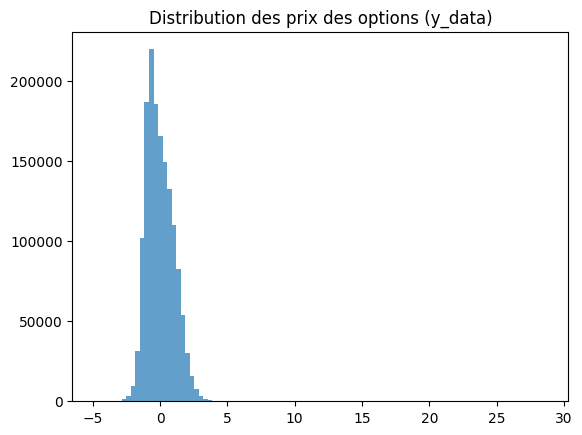

In [12]:
plt.hist(y_train_transform.flatten(), bins=100, alpha=0.7, label='y_train_transform')
plt.title("Distribution des prix des options (y_data)")
plt.show()

## Building a Convolutionnal Neural Network

In [13]:
num_strikes = 11 
num_maturities = 8
output_shape = (num_strikes, num_maturities, 1)

In [14]:
model_cnn_tuned = keras.models.Sequential([
    Dense(128, activation="elu", input_shape=(5,)),
    Dense(num_strikes * num_maturities, activation="elu"),
    Reshape(output_shape),

    Conv2D(32, kernel_size=(3, 3), activation="elu", padding="same"),
    BatchNormalization(),
    Conv2D(32, kernel_size=(3, 3), activation="elu", padding="same"),
    BatchNormalization(),
    Dropout(0.25),  # Adding dropout for regularization

    Conv2D(64, kernel_size=(3, 3), activation="elu", padding="same"),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3, 3), activation="elu", padding="same"),
    BatchNormalization(),
    Dropout(0.25),  # Adding dropout for regularization

    Conv2D(128, kernel_size=(3, 3), activation="elu", padding="same"),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), activation="elu", padding="same"),
    BatchNormalization(),
    Dropout(0.25),  # Adding dropout for regularization

    Conv2D(1, kernel_size=(3, 3), activation="linear", padding="same"),  # Single output per pixel
    Flatten()  # Flatten to vector form (88 option prices)
])

model_cnn_tuned.compile(optimizer="adam", loss="mse")

model_cnn_tuned.summary()

c:\Users\diane\anaconda3\envs\envy\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 88)             │        11,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 11, 8, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 11, 8, 32)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 11, 8, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 8, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 8, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 8, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 8, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 11, 8, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 8, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 11, 8, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 8, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 11, 8, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 8, 128)     │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 11, 8, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 11, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 11, 8, 1)       │         1,153 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 88)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 301,497 (1.15 MB)

 Trainable params: 300,601 (1.15 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

train_hist_cnn_tuned = model_cnn_tuned.fit(x_train_transform, y_train_transform, batch_size=64, epochs=30, validation_data=(x_test_transform, y_test_transform))

Epoch 1/30


c:\Users\cleme\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


266/266 ━━━━━━━━━━━━━━━━━━━━ 50s 186ms/step - loss: 0.9774 - val_loss: 0.9953
Epoch 2/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 48s 180ms/step - loss: 0.2387 - val_loss: 0.5135
Epoch 3/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 186ms/step - loss: 0.2191 - val_loss: 0.2330
Epoch 4/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 50s 188ms/step - loss: 0.2093 - val_loss: 0.2224
Epoch 5/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 50s 187ms/step - loss: 0.2137 - val_loss: 0.2190
Epoch 6/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 50s 187ms/step - loss: 0.2053 - val_loss: 0.2103
Epoch 7/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 185ms/step - loss: 0.2029 - val_loss: 0.2190
Epoch 8/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 48s 179ms/step - loss: 0.1990 - val_loss: 0.2138
Epoch 9/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 44s 167ms/step - loss: 0.1957 - val_loss: 0.2049
Epoch 10/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 45s 168ms/step - loss: 0.1985 - val_loss: 0.2299
Epoch 11/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 45s 170ms/step - loss: 0.2059 - val_loss: 0.1972
Epoch 12/30
266/266 ━━━━━━━━━━

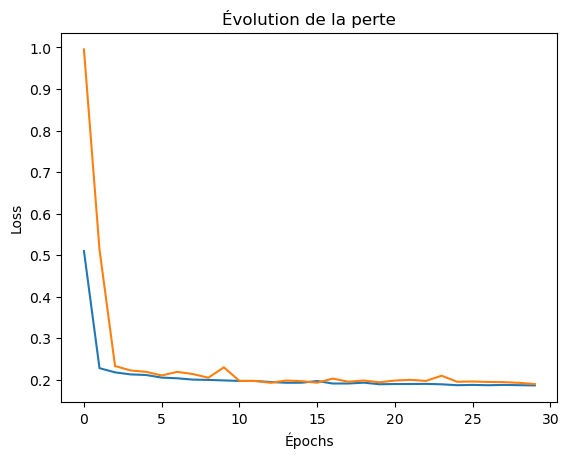

In [31]:
plt.plot(train_hist_cnn_tuned.history['loss'])
plt.plot(train_hist_cnn_tuned.history['val_loss'])
plt.title("Évolution de la perte")
plt.xlabel("Épochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
warnings.filterwarnings('ignore')

test_loss_cnn_tuned = model_cnn_tuned.evaluate(x_test_transform, y_test_transform)
print(f"Test Loss: {test_loss_cnn_tuned}")

 5/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1751

c:\Users\cleme\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1869
Test Loss: 0.18956220149993896


In [33]:
model_cnn_tuned.save_weights('2FBergomiNNWeights_final_batch64.weights.h5')

In [15]:
model_cnn_tuned.load_weights('2FBergomiNNWeights_final_batch64.weights.h5')

c:\Users\diane\anaconda3\envs\envy\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [16]:
print(len(model_cnn_tuned.layers))

20


In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


en gros il y a un pb c'est que notre y_train a pleins de valeurs nulles donc on peut pas trop divisé par ça et je pense que ça biaise toutes les erreurs relatives de rajouter un petit epsilon. 

  3/532 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step

c:\Users\diane\anaconda3\envs\envy\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


532/532 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step


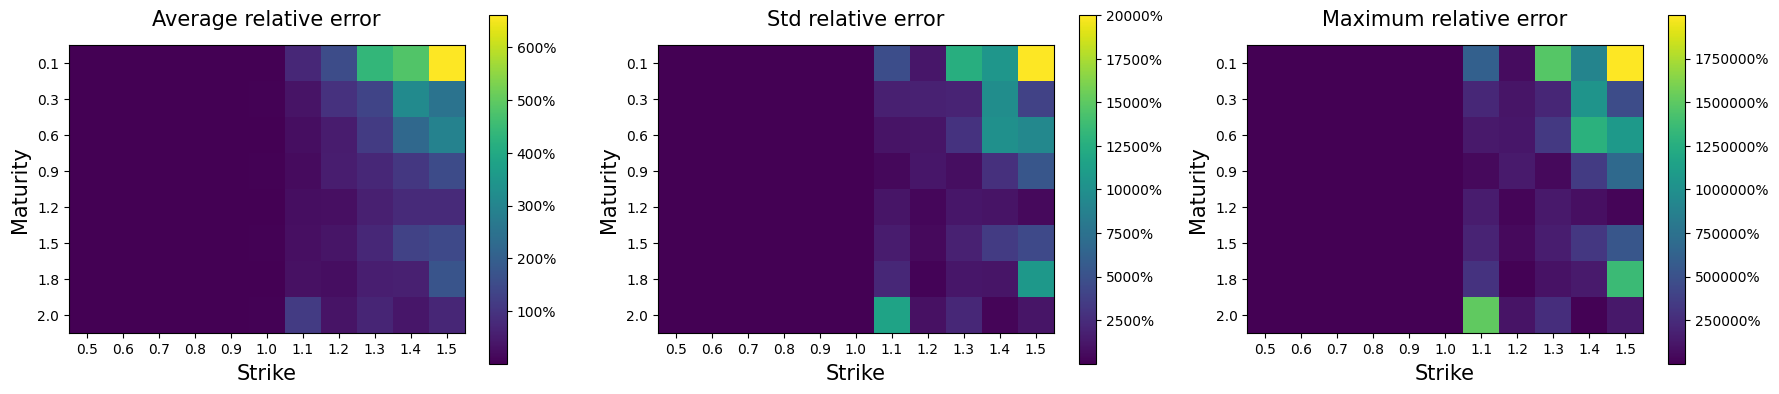

In [50]:
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])
strikes_dim = len(strikes)
maturities_dim = len(maturities)
epsilon = 1

# Étiquettes pour les axes
strikeslabel = np.round(np.linspace(strikes[0], strikes[-1], 8), 1)
maturitieslabel = np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

y_train_safe = np.where(y_train == 0, epsilon, y_train)
y_pred = model_cnn_tuned.predict(x_train_transform).reshape(y_train.shape)
y_pred_1 = output_norm_transform_inv(y_pred, y_mean, y_std).reshape(y_train.shape)

# Étape 2 : Tracer les heatmaps
plt.figure(figsize=(18, 4))

# 🔹 Graphique 1 : Erreur relative moyenne
ax = plt.subplot(1, 3, 1)
err = np.mean(100 * np.abs((y_train_safe - y_pred_1) / y_train_safe), axis=0)
plt.title("Average relative error", fontsize=15, y=1.04)
plt.imshow(err.reshape(maturities_dim, strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0, len(strikes) - 1, len(strikes)))
ax.set_xticklabels(strikes / 100)
ax.set_yticks(np.linspace(0, len(maturities) - 1, len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike", fontsize=15, labelpad=5)
plt.ylabel("Maturity", fontsize=15, labelpad=5)

ax = plt.subplot(1, 3, 2)
err = 100 * np.std(np.abs((y_train_safe - y_pred_1) / y_train_safe), axis=0)
plt.title("Std relative error", fontsize=15, y=1.04)
plt.imshow(err.reshape(maturities_dim, strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0, len(strikes) - 1, len(strikes)))
ax.set_xticklabels(strikes / 100)
ax.set_yticks(np.linspace(0, len(maturities) - 1, len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike", fontsize=15, labelpad=5)
plt.ylabel("Maturity", fontsize=15, labelpad=5)

ax = plt.subplot(1, 3, 3)
err = 100 * np.max(np.abs((y_train_safe - y_pred_1) / y_train_safe), axis=0)
plt.title("Maximum relative error", fontsize=15, y=1.04)
plt.imshow(err.reshape(maturities_dim, strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0, len(strikes) - 1, len(strikes)))
ax.set_xticklabels(strikes / 100)
ax.set_yticks(np.linspace(0, len(maturities) - 1, len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike", fontsize=15, labelpad=5)
plt.ylabel("Maturity", fontsize=15, labelpad=5)

plt.tight_layout()
plt.show()

### Prediction for an existing grid of parameter: (used for training)

We are excpecting the model to do well as he learnt from those parameters in particular.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


c:\Users\diane\anaconda3\envs\envy\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


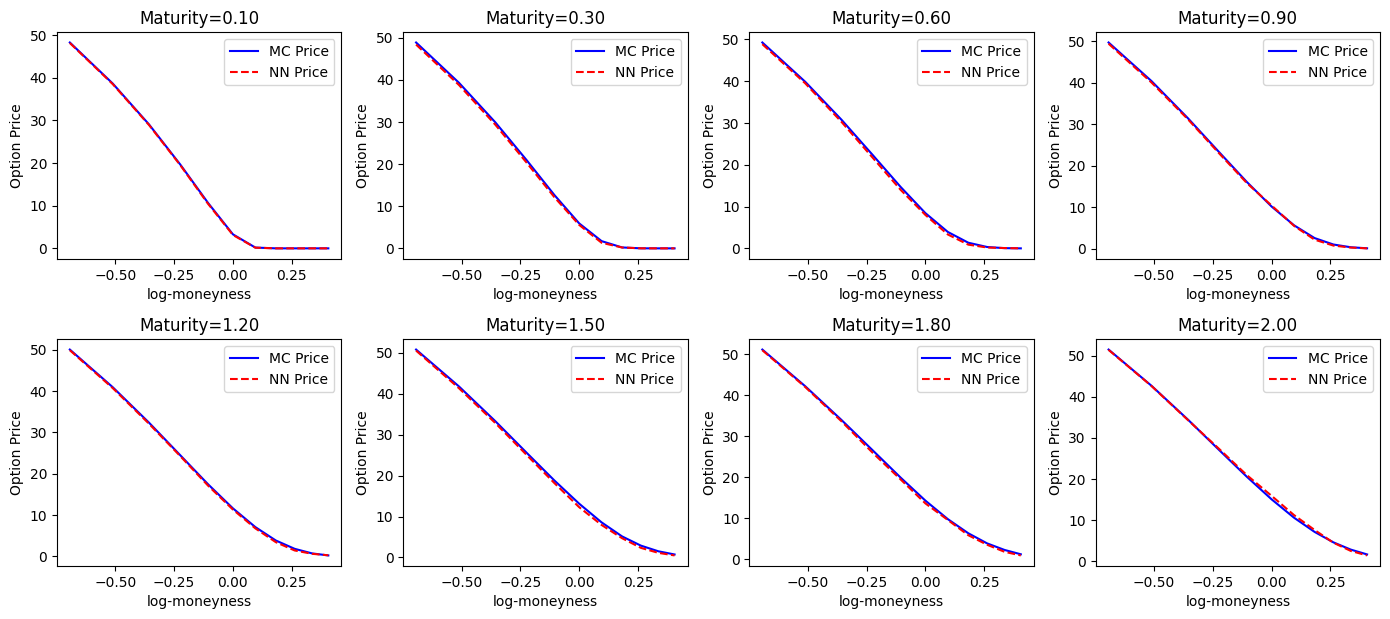

In [51]:
import numpy as np
import matplotlib.pyplot as plt

sample_ind = 100
X_input = X_test[sample_ind]

X_input_transform = input_norm_transform(X_input, x_min, x_max, x_norm_min, x_norm_max)

y_true = np.exp(y_test[sample_ind])-1
y_pred = np.exp(output_norm_transform_inv(model_cnn_tuned.predict(X_input_transform.reshape(1, -1)), y_mean, y_std))-1

plt.figure(figsize=(14, 12))
for i in range(maturities_dim):
    plt.subplot(4, 4, i + 1)

    plt.plot(np.log(strikes / S0), y_true[i * strikes_dim:(i + 1) * strikes_dim], 'b', label="MC Price")

    plt.plot(np.log(strikes / S0), y_pred[0, i * strikes_dim:(i + 1) * strikes_dim], '--r', label="NN Price")

    plt.title(f"Maturity={maturities[i]:.2f}")
    plt.xlabel("log-moneyness")
    plt.ylabel("Option Price")
    plt.legend()

plt.tight_layout()
plt.show()


## Final predictions

### parameter set 1

$\xi = 0.06, \kappa_1 =41.6, \eta_1 = 18.2428, \eta_2 = 3.43, \rho = -0.7$

In [37]:
xi = 0.06
kappa = 41.6
eta_1 = 18.2428
eta_2 = 3.43
rho = -0.7

X_input = np.array([[xi, kappa, eta_1, eta_2, rho]])
X_input_norm = input_norm_transform(X_input, x_min, x_max, x_norm_min, x_norm_max)

y_pred_norm = model_cnn_tuned.predict(X_input_norm)

y_pred_1 = output_norm_transform_inv(y_pred_norm, y_mean, y_std)

print("Predicted option prices for parameter set 1:", np.exp(y_pred_1)-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted option prices for parameter set 1: [[ 4.81567508e+01  3.85548046e+01  2.89758575e+01  1.94574315e+01
   1.00972971e+01  1.80641240e+00  6.72192013e-02  1.58036748e-02
   7.47320979e-03  1.84421022e-03 -3.86044244e-04  4.84300550e+01
   3.88372533e+01  2.93228466e+01  1.99514452e+01  1.08988296e+01
   2.98349132e+00  2.94529722e-01  7.09261105e-02  3.61058061e-02
   1.65815092e-02  1.64636852e-02  4.88878944e+01  3.93429676e+01
   2.98480340e+01  2.05364439e+01  1.16668480e+01  4.06797836e+00
   6.84274896e-01  2.03160217e-01  9.02455877e-02  5.75575432e-02
   4.18544162e-02  4.92714549e+01  3.97174606e+01  3.03554810e+01
   2.11589222e+01  1.25149015e+01  5.10924749e+00  1.25601104e+00
   4.53975302e-01  2.03570119e-01  9.82254025e-02  6.54096586e-02
   4.96798923e+01  4.01512117e+01  3.08117073e+01  2.17262431e+01
   1.32359077e+01  5.95068313e+00  1.81062345e+00  6.60239221e-01
   2.99629060e-01  1.54712270e-01  9.79870795e-02  5.013805

c:\Users\diane\anaconda3\envs\envy\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


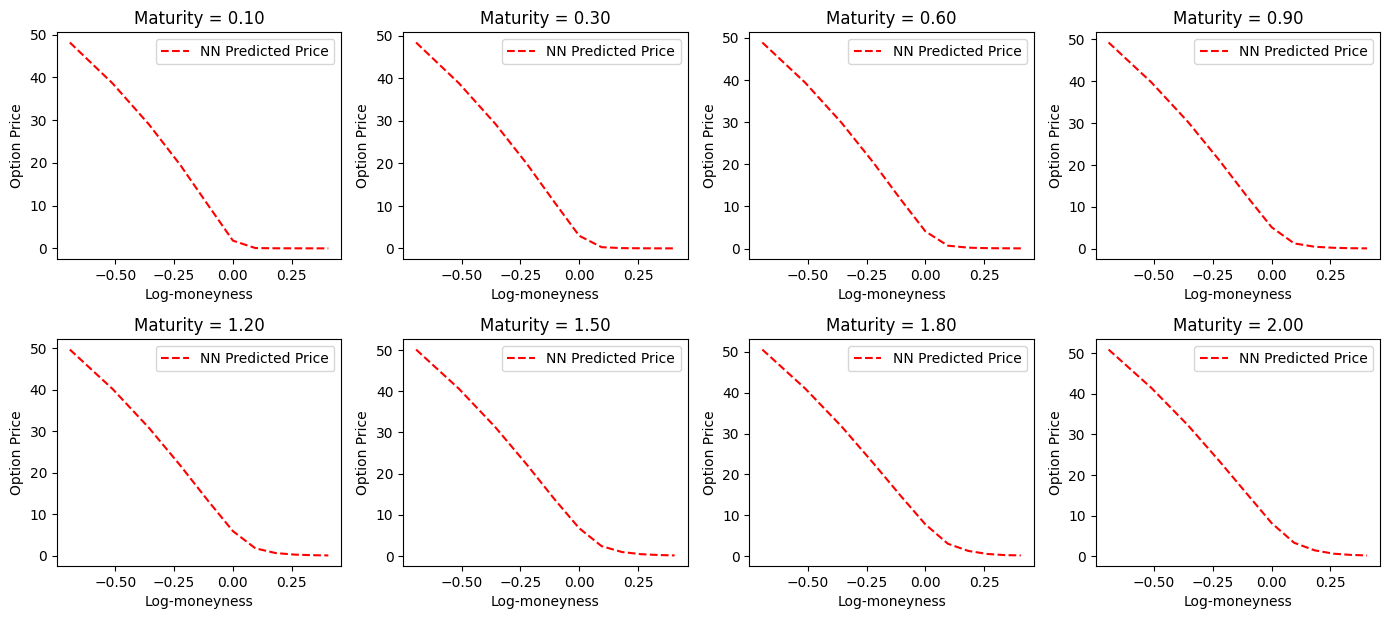

In [39]:
y_pred_exp = np.exp(y_pred_1)-1

plt.figure(figsize=(14, 12))
for i in range(maturities_dim):
    plt.subplot(4, 4, i + 1)

    plt.plot(np.log(strikes / S0), y_pred_exp[0, i * strikes_dim:(i + 1) * strikes_dim], 'r', linestyle="--", label="NN Predicted Price")

    plt.title(f"Maturity = {maturities[i]:.2f}")
    plt.xlabel("Log-moneyness")
    plt.ylabel("Option Price")
    plt.legend()

plt.tight_layout()
plt.show()

### parameter set 2

$\xi = 0.1, \kappa_1 = 15.6, \eta_1 = 5.5857, \eta_2 = 2.2867, \rho = -0.4$

In [40]:
xi = 0.1
kappa = 15.6
eta_1 = 5.5857
eta_2 = 2.2867
rho = -0.4

X_input = np.array([[xi, kappa, eta_1, eta_2, rho]])
X_input_norm = input_norm_transform(X_input, x_min, x_max, x_norm_min, x_norm_max)

y_pred_norm = model_cnn_tuned.predict(X_input_norm)

y_pred_2 = output_norm_transform_inv(y_pred_norm, y_mean, y_std)

print("Predicted option prices for parameter set 2:", np.exp(y_pred_2)-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted option prices for parameter set 2: [[4.81514702e+01 3.85469095e+01 2.89862523e+01 1.95422549e+01
  1.05535029e+01 3.37280194e+00 5.41633572e-01 1.15231629e-01
  3.22080493e-02 1.45330426e-02 9.77615601e-03 4.84619266e+01
  3.89219069e+01 2.95510640e+01 2.05155645e+01 1.22266839e+01
  5.49350282e+00 1.83022182e+00 6.45168681e-01 2.97454857e-01
  1.62056883e-01 1.05508309e-01 4.90435670e+01 3.96435424e+01
  3.04532535e+01 2.17567162e+01 1.38168208e+01 7.42637575e+00
  3.74118402e+00 1.77868210e+00 9.96738534e-01 5.93335410e-01
  3.33662704e-01 4.95614624e+01 4.02403262e+01 3.13357294e+01
  2.29505348e+01 1.54977037e+01 9.88892216e+00 5.58468220e+00
  2.91526775e+00 1.64550779e+00 1.04768170e+00 6.98472253e-01
  5.01714032e+01 4.10639386e+01 3.24142241e+01 2.43427002e+01
  1.67277115e+01 1.07141930e+01 6.40393123e+00 3.76702438e+00
  2.56798822e+00 1.76359840e+00 1.20807309e+00 5.07900704e+01
  4.17395478e+01 3.30973122e+01 2.51286742e+01 1.

c:\Users\diane\anaconda3\envs\envy\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


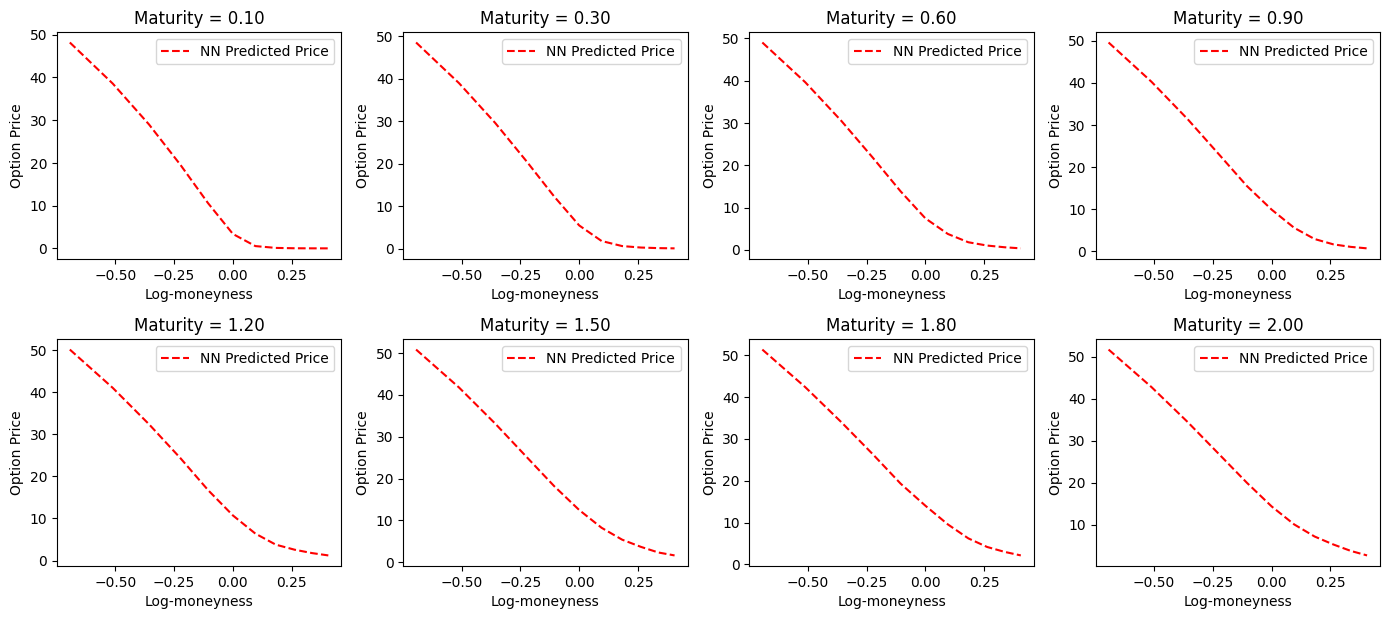

In [41]:
y_pred_exp = np.exp(y_pred_2)-1

plt.figure(figsize=(14, 12))
for i in range(maturities_dim):
    plt.subplot(4, 4, i + 1)

    plt.plot(np.log(strikes / S0), y_pred_exp[0, i * strikes_dim:(i + 1) * strikes_dim], 'r', linestyle="--", label="NN Predicted Price")

    plt.title(f"Maturity = {maturities[i]:.2f}")
    plt.xlabel("Log-moneyness")
    plt.ylabel("Option Price")
    plt.legend()

plt.tight_layout()
plt.show()

### parameter set 3

$\xi = 0.2, \kappa_1 = 54.6, \eta_1 = 31.3496, \eta_2 = 4.5733, \rho = -0.8$

In [43]:
xi = 0.2
kappa = 54.6
eta_1 = 31.3496
eta_2 = 4.5733
rho = -0.8

X_input = np.array([[xi, kappa, eta_1, eta_2, rho]])
X_input_norm = input_norm_transform(X_input, x_min, x_max, x_norm_min, x_norm_max)

y_pred_norm = model_cnn_tuned.predict(X_input_norm)

y_pred_3 = output_norm_transform_inv(y_pred_norm, y_mean, y_std)

print("Predicted option prices for parameter set 3:", np.exp(y_pred_3)-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Predicted option prices for parameter set 3: [[4.82159256e+01 3.86609268e+01 2.91291825e+01 1.96736947e+01
  1.03607118e+01 2.04846169e+00 1.54121505e-01 6.52000287e-02
  3.65295602e-02 2.27764294e-02 1.46967242e-02 4.85864359e+01
  3.90624736e+01 2.96228252e+01 2.03165667e+01 1.12060475e+01
  3.04930702e+00 4.93528577e-01 2.05580639e-01 1.14319358e-01
  6.35345580e-02 4.62421434e-02 4.91148633e+01 3.96622055e+01
  3.02014949e+01 2.10043491e+01 1.20344261e+01 4.15847736e+00
  9.85390690e-01 4.45695164e-01 2.66888393e-01 1.69910725e-01
  1.26066181e-01 4.96047293e+01 4.01221120e+01 3.07983978e+01
  2.17209846e+01 1.30357509e+01 5.28450096e+00 1.51602303e+00
  7.00711267e-01 4.21457859e-01 2.73309997e-01 1.94118344e-01
  5.00584583e+01 4.06617130e+01 3.13833062e+01 2.23188318e+01
  1.36550505e+01 6.06656803e+00 2.06366274e+00 9.93617236e-01
  6.15137779e-01 3.82475683e-01 2.73529529e-01 5.05663339e+01
  4.11924170e+01 3.19395544e+01 2.28952271e+01 1.

c:\Users\diane\anaconda3\envs\envy\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


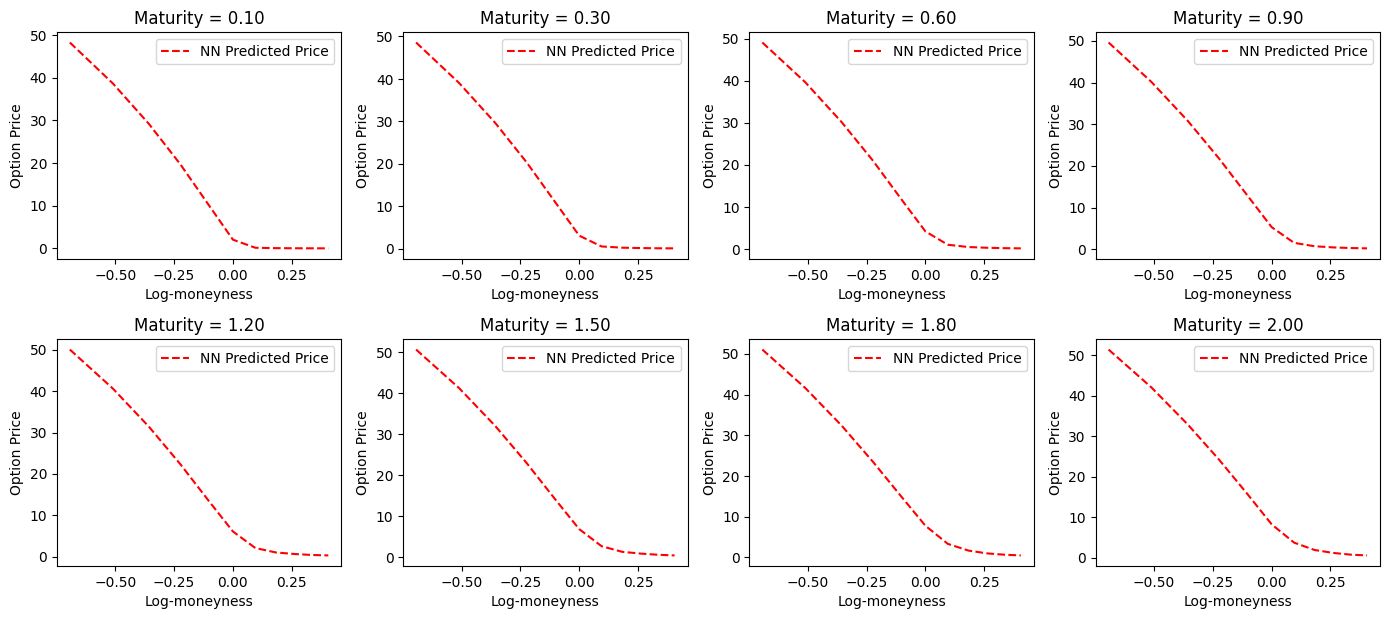

In [44]:
y_pred_exp = np.exp(y_pred_3)-1

plt.figure(figsize=(14, 12))
for i in range(maturities_dim):
    plt.subplot(4, 4, i + 1)

    plt.plot(np.log(strikes / S0), y_pred_exp[0, i * strikes_dim:(i + 1) * strikes_dim], 'r', linestyle="--", label="NN Predicted Price")

    plt.title(f"Maturity = {maturities[i]:.2f}")
    plt.xlabel("Log-moneyness")
    plt.ylabel("Option Price")
    plt.legend()

plt.tight_layout()
plt.show()

# References

1)  Lorenzo Bergomi. Smile dynamics II. Risk Magazine, 2005

2) Blanka Horvath, Aitor Muguruza, and Mehdi Tomas. Deep learning volatility: a deep neural 
network perspective on pricing and calibration in (rough) volatility models. Quantitativ 
Finance, 21(1):11–27, 20218

3) Ryan McCrickerd and Mikko S Pakkanen. Turbocharging monte carlo pricing for the rough 
bergomi model. Quantitative Finance, 18(11):1877–1886, 2018